Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Подготавливаем данные на основе выводов из EDA.

In [2]:
df = pd.read_excel('data/data.xlsx', index_col=0) 
target_vars = ['IC50, mM', 'CC50, mM', 'SI']
target = 'CC50, mM'

numeric_cols = df.select_dtypes(include=[np.number]).columns
feature_cols = [col for col in numeric_cols if col not in target_vars and col != df.columns[0]]

X = df[feature_cols]
y = df[target]

print(f"Исходные данные: {X.shape[0]} образцов, {X.shape[1]} признаков")
y_log = np.log10(y + 1e-10)
print(f"Применено логарифмическое преобразование целевой переменной")

print(f"\nСтатистика CC50:")
print(f"Среднее: {y.mean():.1f} mM")
print(f"Медиана: {y.median():.1f} mM")
print(f"Диапазон: {y.min():.1f} - {y.max():.1f} mM")

X_clean = X.loc[:, X.std() > 0]
print(f"Удалено {X.shape[1] - X_clean.shape[1]} константных признаков")

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X_clean), columns=X_clean.columns)
print(f"Заполнены пропущенные значения")

corr_matrix = X_imputed.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = []
for column in upper_triangle.columns:
    if any(upper_triangle[column] > 0.95):
        to_drop.append(column)

X_final = X_imputed.drop(columns=to_drop)
print(f"Удалено {len(to_drop)} высококоррелированных признаков")
print(f"Финальные данные: {X_final.shape[1]} признаков\n")

Исходные данные: 1001 образцов, 210 признаков
Применено логарифмическое преобразование целевой переменной

Статистика CC50:
Среднее: 589.1 mM
Медиана: 411.0 mM
Диапазон: 0.7 - 4539.0 mM
Удалено 18 константных признаков
Заполнены пропущенные значения
Удалено 33 высококоррелированных признаков
Финальные данные: 159 признаков



Разделим датасет на тренировочную и тестовые выборки и стандартизируем

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_log, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

selector = SelectKBest(score_func=f_regression, k=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features = X_train_scaled.columns[selector.get_support()]
print(f"Отобрано {len(selected_features)} лучших признаков\n")

Обучающая выборка: (800, 159)
Тестовая выборка: (201, 159)
Отобрано 50 лучших признаков



Определяем набор моделей для обучения и начальные гиперпараметры

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=2000),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'SVR': SVR()
}
param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1.0]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVR': {'C': [0.1, 1.0, 10.0], 'gamma': ['scale', 'auto']}
}

Обучение моделей

In [ ]:
results = {}

for name, model in models.items():
    print(f"Обучение {name}...")
    
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, 
                                 scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_selected, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train_selected, y_train)
    
    y_pred_train = best_model.predict(X_train_selected)
    y_pred_test = best_model.predict(X_test_selected)
    
 
    y_true_train = np.power(10, y_train)
    y_true_test = np.power(10, y_test)
    y_pred_train_actual = np.power(10, y_pred_train)
    y_pred_test_actual = np.power(10, y_pred_test)
    
 
    train_rmse = np.sqrt(mean_squared_error(y_true_train, y_pred_train_actual))
    test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test_actual))
    train_r2 = r2_score(y_true_train, y_pred_train_actual)
    test_r2 = r2_score(y_true_test, y_pred_test_actual)
    test_mae = mean_absolute_error(y_true_test, y_pred_test_actual)
    
    cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, 
                               scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    results[name] = {
        'model': best_model,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'cv_rmse': cv_rmse,
        'y_true': y_true_test,
        'y_pred': y_pred_test_actual
    }
    
    print(f"RMSE: {test_rmse:.1f}, R²: {test_r2:.3f}")


Обучение Linear Regression...
RMSE: 615.5, R²: 0.269
Обучение Ridge...
RMSE: 632.0, R²: 0.230
Обучение Lasso...
RMSE: 624.7, R²: 0.247
Обучение Random Forest...
RMSE: 526.5, R²: 0.465
Обучение SVR...
RMSE: 511.6, R²: 0.495


Лучшая модель

In [ ]:
results_df = pd.DataFrame({
    name: {
        'Test RMSE': result['test_rmse'],
        'Test R²': result['test_r2'],
        'Test MAE': result['test_mae'],
        'CV RMSE': result['cv_rmse']
    } for name, result in results.items()
}).T.sort_values('Test RMSE')
best_model_name = results_df.index[0]
best_result = results[best_model_name]

print(f"Лучшая модель: {best_model_name}")
print(f"Test RMSE: {best_result['test_rmse']:.1f} mM")
print(f"Test R²: {best_result['test_r2']:.3f}")
print(f"Test MAE: {best_result['test_mae']:.1f} mM")

Лучшая модель: SVR
   Test RMSE: 511.6 mM
   Test R²: 0.495
   Test MAE: 307.9 mM


Визуализация результатов региссионного анализа

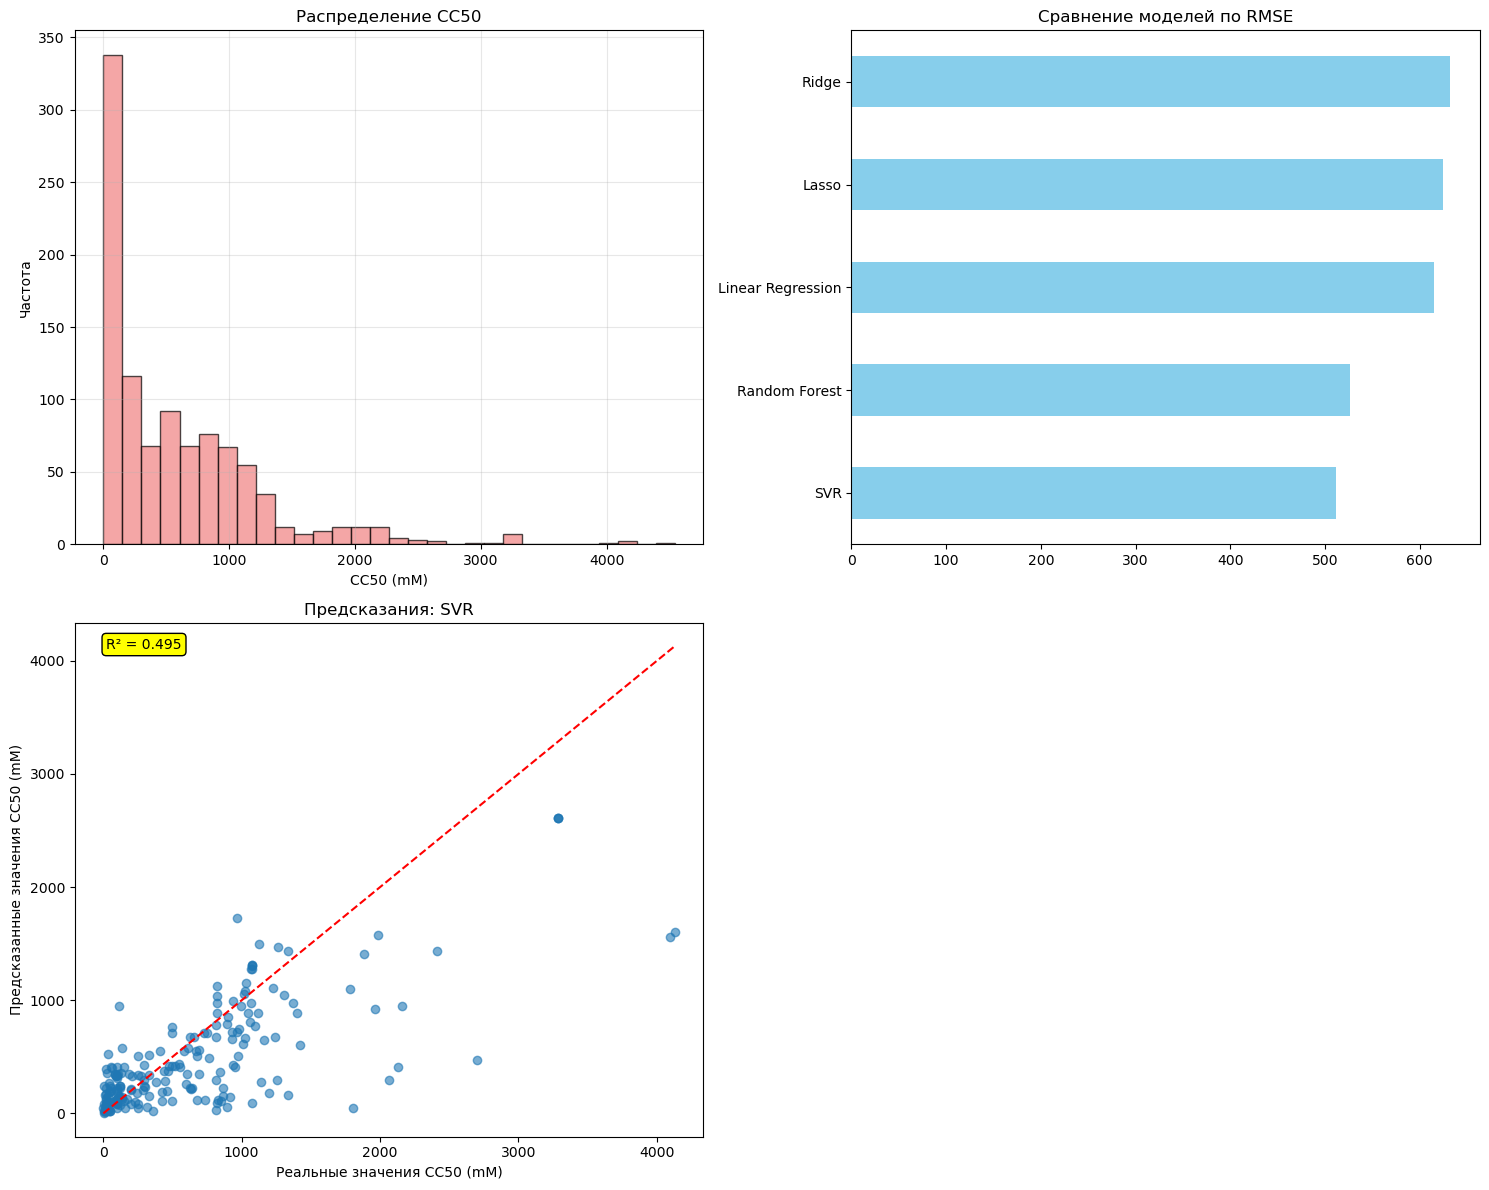

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].hist(y, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
axes[0,0].set_xlabel('CC50 (mM)')
axes[0,0].set_ylabel('Частота')
axes[0,0].set_title('Распределение CC50')
axes[0,0].grid(True, alpha=0.3)

results_df['Test RMSE'].plot(kind='barh', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Сравнение моделей по RMSE')

y_true = best_result['y_true']
y_pred = best_result['y_pred']

axes[1,0].scatter(y_true, y_pred, alpha=0.6)
axes[1,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
axes[1,0].set_xlabel('Реальные значения CC50 (mM)')
axes[1,0].set_ylabel('Предсказанные значения CC50 (mM)')
axes[1,0].set_title(f'Предсказания: {best_model_name}')
axes[1,0].text(0.05, 0.95, f'R² = {best_result["test_r2"]:.3f}', 
               transform=axes[1,0].transAxes, bbox=dict(boxstyle="round", facecolor='yellow'))
axes[1,1].axis('off')

plt.tight_layout()
plt.show()
